# White Dwarf B - Operating Conditions (Fuel 60% IPA, 40% water, by mass)

Copper jacket, milled cooling channels, water coolant.

In [22]:
# Import required modules
import bamboo as bam
import bamboo.cooling as cool
import bamboo.materials


import numpy as np
import matplotlib.pyplot as plt
import pypropep as ppp
import bamboo.plot
from CoolProp.CoolProp import PropsSI

### Equilibrium calculations

In [23]:
# CHAMBER CONDITIONS
pc = 10e5                   # Chamber pressure (Pa)
thrust = 1.5e3              # Desired thrust (N)
p_amb = 1.01325e5           # Ambient pressure (Pa). 1.01325e5 is sea level atmospheric.
OF_ratio = 3.5              # Oxidiser/fuel mass ratio
water_mass_fraction = 0.40  # Fraction of the fuel that is water, by mass

# COMBUSTION USING PYPROPEP
ppp.init()
p_froz = ppp.FrozenPerformance()
p_shift = ppp.ShiftingPerformance()

ipa = ppp.PROPELLANTS['ISOPROPYL ALCOHOL']
water = ppp.PROPELLANTS['WATER']
n2o = ppp.PROPELLANTS['NITROUS OXIDE']

p_froz.add_propellants_by_mass([(ipa, 1-water_mass_fraction), (water, water_mass_fraction), (n2o, OF_ratio)])
p_shift.add_propellants_by_mass([(ipa, 1-water_mass_fraction), (water, water_mass_fraction), (n2o, OF_ratio)])
                  
p_froz.set_state(P = pc/1e5, Pe = p_amb/1e5)                      
p_shift.set_state(P = pc/1e5, Pe = p_amb/1e5)                      

gamma = p_froz.properties[1].Isex   # Index 0 means chamber conditions, 1 means throat. pyrpopep uses 'Isex' for the ratio of specific heats
cp = 1000*p_froz.properties[1].Cp   # Cp is given in kJ/kg/K, we want J/kg/K
Tc = p_froz.properties[0].T

isp_froz = p_froz.performance.Isp
isp_shift = p_shift.performance.Isp

mdot = thrust/isp_froz        # We'll use frozen flow isp to choose the mass flow rate

# Set up engine object
perfect_gas = bam.PerfectGas(gamma = gamma, cp = cp)    #Gas for frozen flow
chamber_conditions = bam.ChamberConditions(pc, Tc, mdot)
nozzle = bam.Nozzle.from_engine_components(perfect_gas, chamber_conditions, p_amb, type = "rao")
engine = bam.Engine(perfect_gas, chamber_conditions, nozzle)

# Chamber and wall geometry
Rc = 121e-3/2
Dc = 2*Rc
Dt = 2*(nozzle.At/np.pi)**0.5
Ac = np.pi*Rc**2   
L_star = 1.2                                 # L_star = Volume_c/Area_t
Vc = L_star * nozzle.At

# Equation (1.34) from http://www.braeunig.us/space/propuls.htm 
Lc = ( 24*Vc/np.pi - (Dc**3 - Dt**3)/np.tan(45*np.pi/180) ) / (6*Dc**2)   

inner_wall_thickness = 1e-3
outer_wall_thickness = 0.5e-3
engine.add_geometry(chamber_length = Lc,
                    chamber_area = Ac,
                    inner_wall_thickness = inner_wall_thickness,
                    outer_wall_thickness = outer_wall_thickness)


Loaded 1921 thermo species
Loaded 1031 propellants
NOTE: Area ratio is outside of data range for Rao bell nozzle graphs (minimum 3.7, maximum 47). Using a 15 deg cone nozzle instead.


### Engine performance and geometry

In [24]:
At_froz = p_froz._equil_structs[1].performance.a_dotm * mdot / 101325  # PyProPEP uses units of atm, need to convert to Pa
At_shift = p_shift._equil_structs[1].performance.a_dotm * mdot / 101325

Ae_froz = p_froz.performance.ae_at * At_froz
Ae_shift = p_shift.performance.ae_at * At_shift

print(f"""
OPERATING CONDITIONS
Mass flow rate = {mdot:.3f} kg/s

Sea level thrust     = {engine.thrust(1e5)/1000:.3f} kN      (perfect gas relations)
Sea level thrust     = {isp_froz * mdot/1000:.3f} kN      (frozen flow - PyProPEP)
Sea level thrust     = {isp_shift * mdot/1000:.3f} kN      (equilibrium flow - PyProPEP)

Sea level Isp        = {engine.isp(1e5):.3f} s     (perfect gas relations)
Sea level Isp        = {isp_froz/9.80665:.3f} s     (frozen flow - PyProPEP)
Sea level Isp        = {isp_shift/9.80665:.3f} s     (equilibrium flow - PyProPEP)

Chamber Temperature  = {Tc:.3f} K
Gamma                = {gamma:.3f}
cp                   = {cp:.3f} J/kg/K
""")

print(f"""
GEOMETRY
Chamber length       = {Lc:.5f} m (injector face to start of converging section)   
Nozzle length (total)= {engine.geometry.x_max - engine.geometry.x_chamber_end:.5f} m (start of converging section to exit)
Total engine length  = {Lc + engine.geometry.x_max - engine.geometry.x_chamber_end:.5f} m (injector face to nozzle exit)

Throat area          = {nozzle.At:.5f} m^2  (Bamboo - perfect gas)
Throat area          = {At_froz:.5f} m^2  (PyProPEP - frozen flow)
Throat area          = {At_shift:.5f} m^2  (PyProPEP - equilibrium flow)

Throat radius        = {1e3*(nozzle.At/np.pi)**0.5:.1f} mm  (Bamboo - perfect gas)
Throat radius        = {1e3*(At_froz/np.pi)**0.5:.1f} mm  (PyProPEP - frozen flow)
Throat radius        = {1e3*(At_shift/np.pi)**0.5:.1f} mm  (PyProPEP - equilibrium flow)

Exit area            = {nozzle.Ae:.5f} m^2  (Bamboo - perfect gas)
Exit area            = {Ae_froz:.5f} m^2  (PyProPEP - frozen flow)
Exit area            = {Ae_shift:.5f} m^2  (PyProPEP - frozen flow)

Exit radius          = {1e3*(nozzle.Ae/np.pi)**0.5:.1f} mm  (Bamboo - perfect gas)
Exit radius          = {1e3*(Ae_froz/np.pi)**0.5:.1f} mm  (PyProPEP - frozen flow)
Exit radius          = {1e3*(Ae_shift/np.pi)**0.5:.1f} mm  (PyProPEP - equilibrium flow)
""")




OPERATING CONDITIONS
Mass flow rate = 0.803 kg/s

Sea level thrust     = 1.504 kN      (perfect gas relations)
Sea level thrust     = 1.500 kN      (frozen flow - PyProPEP)
Sea level thrust     = 1.546 kN      (equilibrium flow - PyProPEP)

Sea level Isp        = 190.922 s     (perfect gas relations)
Sea level Isp        = 190.398 s     (frozen flow - PyProPEP)
Sea level Isp        = 196.176 s     (equilibrium flow - PyProPEP)

Chamber Temperature  = 2868.057 K
Gamma                = 1.227
cp                   = 1761.882 J/kg/K


GEOMETRY
Chamber length       = 0.10450 m (injector face to start of converging section)   
Nozzle length (total)= 0.08885 m (start of converging section to exit)
Total engine length  = 0.19335 m (injector face to nozzle exit)

Throat area          = 0.00119 m^2  (Bamboo - perfect gas)
Throat area          = 0.00117 m^2  (PyProPEP - frozen flow)
Throat area          = 0.00120 m^2  (PyProPEP - equilibrium flow)

Throat radius        = 19.4 mm  (Bamboo - perfec

### Water cooled channels

In [25]:
# Coolant jacket
mdot_coolant = 1                                      # Coolant mass flow rate (kg/s) - 1 kg/s ~= 60 litre/min for water
inlet_T = 298.15                                      # Coolant inlet temperature (K)
inlet_p0 = 1.01325e5                                  # Tank / inlet coolant stagnation pressure (Pa)
inner_wall_material = bam.materials.CopperC700        # Copper inner wall
outer_wall_material = bam.materials.StainlessSteel304 # Steel outer wall
ideal_channel_height = 1.4e-3
number_of_ribs = 100

# Correct for the extra flow area due to the copper-stainless gap. We'll do this by just altering the blockage ratio and increasing channel height.
ideal_blockage_ratio = 0.4                            # Fraction of area that is blocked by 'fins' - ignoring copper-stainless gap
copper_stainless_gap = 0.1e-3                        # Gap between fin tips and stainless ID, to allow for thermal expansion
blocked_area = ( np.pi*(Rc + inner_wall_thickness + ideal_channel_height)**2 - np.pi*(Rc + inner_wall_thickness)**2) * ideal_blockage_ratio
total_area = np.pi*(Rc + inner_wall_thickness + ideal_channel_height + copper_stainless_gap)**2 - np.pi*(Rc + inner_wall_thickness)**2
blockage_ratio = blocked_area/total_area       
channel_height = ideal_channel_height + copper_stainless_gap
print(f"Corrected blockage ratio = {blockage_ratio}")
print(f"Corrected channel height = {channel_height/1e-3} mm")

# Transport property functions
def Pr_exhaust(T, p):
    return PropsSI("PRANDTL", "T", T, "P", p, "NITROGEN")

def mu_exhaust(T, p):
    return PropsSI("VISCOSITY", "T", T, "P", p, "NITROGEN")

def k_exhaust(T, p):
    return PropsSI("CONDUCTIVITY", "T", T, "P", p, "NITROGEN")


def Pr_coolant(T, p):
    try:
        return PropsSI("PRANDTL", "T", T, "P", p, "WATER")
    except ValueError:
        return PropsSI("PRANDTL", "Q", 0, "P", p, "WATER")

def mu_coolant(T, p):
    try:
        return PropsSI("VISCOSITY", "T", T, "P", p, "WATER")
    except ValueError:
        return PropsSI("VISCOSITY", "Q", 0, "P", p, "WATER")

def k_coolant(T, p):
    try:
        return PropsSI("CONDUCTIVITY", "T", T, "P", p, "WATER")
    except ValueError:
        return PropsSI("CONDUCTIVITY", "Q", 0, "P", p, "WATER")

def rho_coolant(T, p):
    try:
        return PropsSI("DMASS", "T", T, "P", p, "WATER")
    except ValueError:
        return PropsSI("DMASS", "Q", 0, "P", p, "WATER")

def cp_coolant(T, p):
    try:
        return PropsSI("CPMASS", "T", T, "P", p, "WATER")
    except ValueError:
        return PropsSI("CPMASS", "Q", 0, "P", p, "WATER")

def T_from_h(enthalpy, p):
    return PropsSI("T", "H", enthalpy, "P", p, "WATER")

def h_from_T(T, p):
    return PropsSI("H", "T", T, "P", p, "WATER")

# Transport property objects
gas_transport = bam.cooling.TransportProperties(type = "functions",
                                                Pr = Pr_exhaust,
                                                mu = mu_exhaust,
                                                k = k_exhaust)

coolant_transport = bam.cooling.TransportProperties(type = "functions",
                                                    Pr = Pr_coolant,
                                                    mu = mu_coolant,
                                                    k = k_coolant,
                                                    cp = cp_coolant,
                                                    rho = rho_coolant,
                                                    T_from_enthalpy = T_from_h,
                                                    enthalpy_from_T = h_from_T)


# Add exhaust transport properties
engine.add_exhaust_transport(gas_transport)

# Add cooling jacket
engine.add_cooling_jacket(inner_wall_material, 
                               inlet_T, 
                               inlet_p0, 
                               coolant_transport, 
                               mdot_coolant, 
                               configuration = "vertical", 
                               channel_height = channel_height,
                               blockage_ratio = blockage_ratio,
                               number_of_ribs = number_of_ribs,
                               outer_wall_material = outer_wall_material)

# Graphite refractory
ablative_material = bam.materials.Graphite
engine.add_ablative(ablative_material)

#Run simulation
heating_data = engine.steady_heating_analysis(to_json = False, 
                                              h_gas_model = 'bartz-sigma', 
                                              h_coolant_model = 'gnielinski')

print(f"Maximum temperature = {max(heating_data['T_wall_inner']) - 273.15} deg C")

Corrected blockage ratio = 0.3730334672021405
Corrected channel height = 1.5 mm
Coolant stagnation pressure dropped below chamber pressure (10.0 bar) at x = 0.03552347494530855, the coolant would not flow in real life.
Maximum temperature = 127.13005818253691 deg C


### Plot temperatures

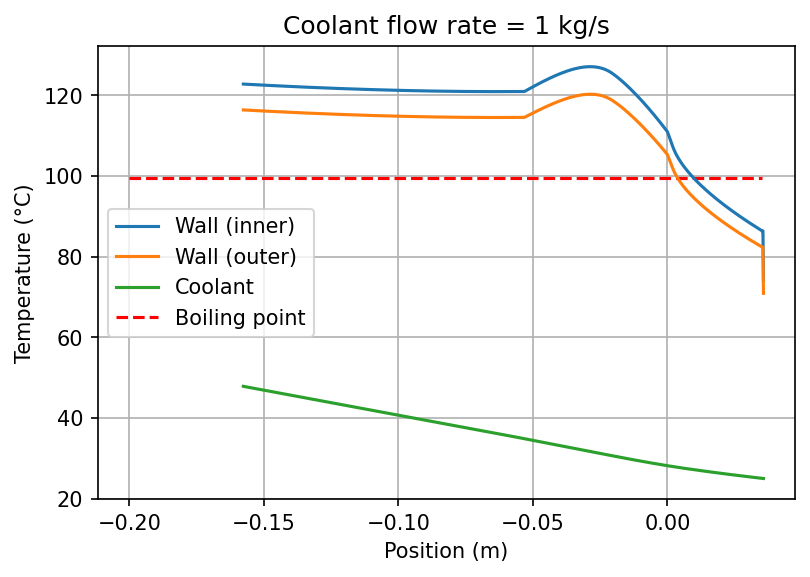

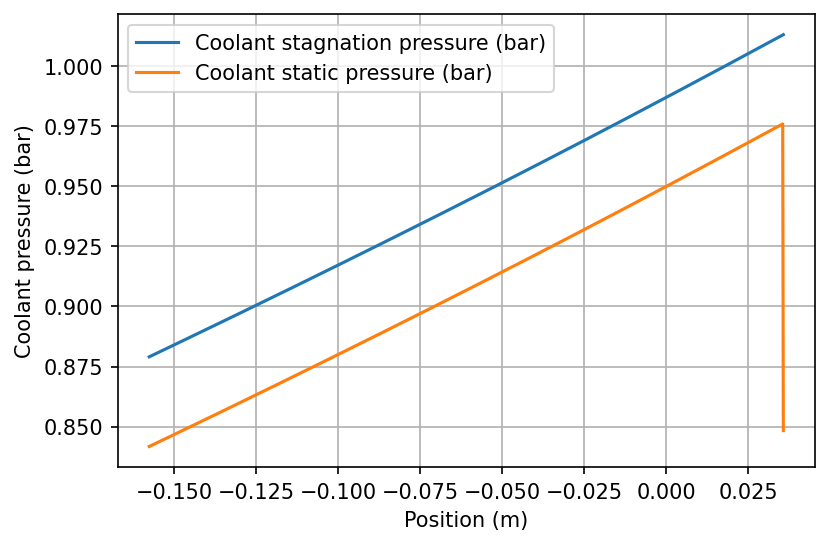

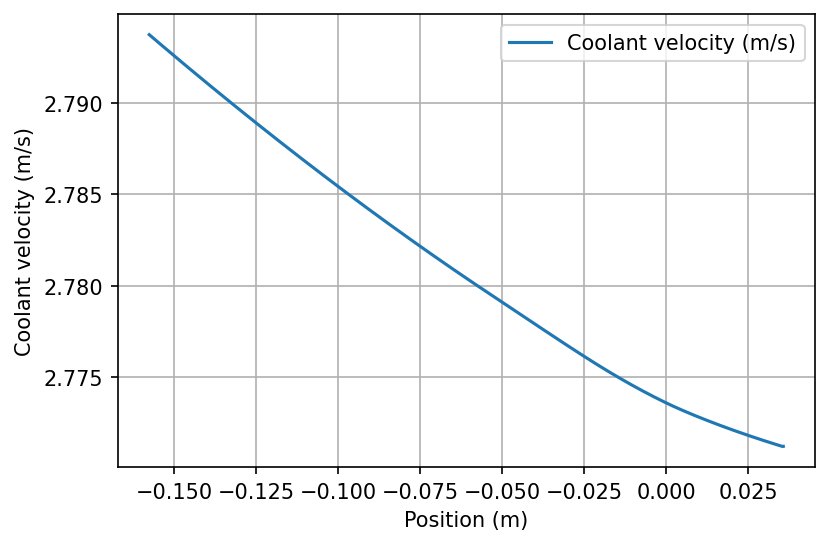

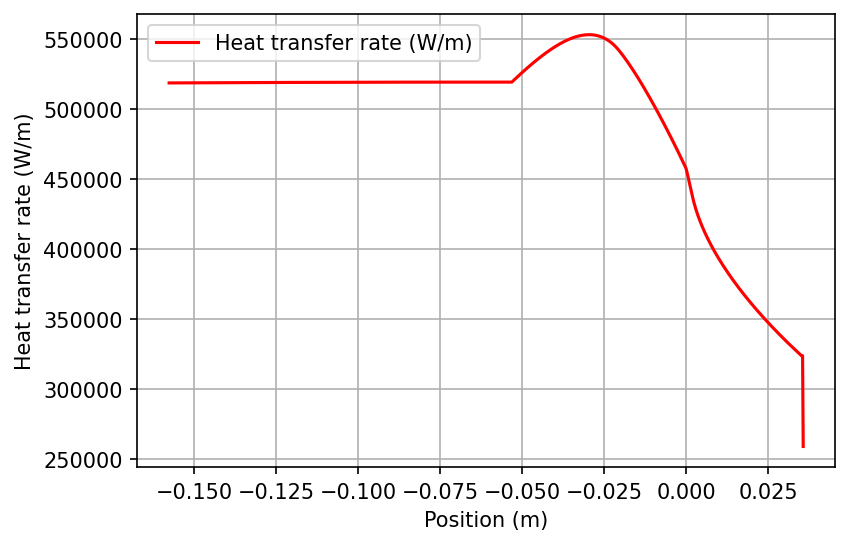

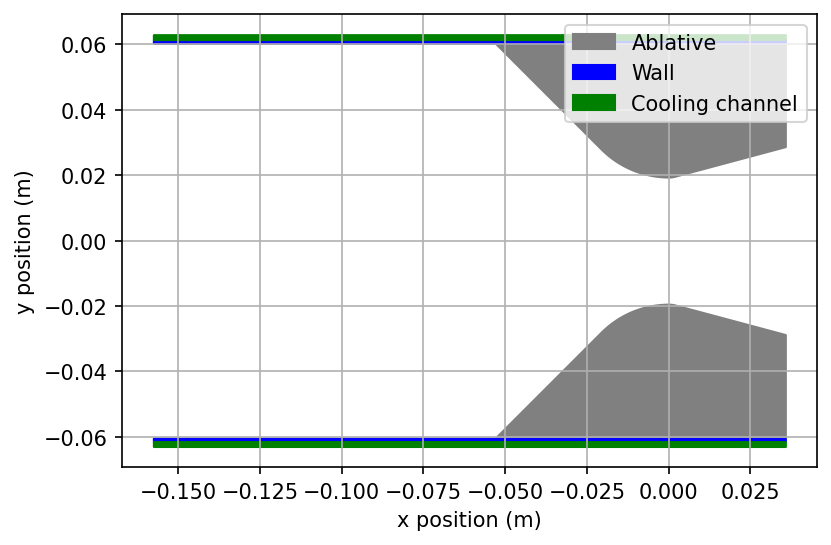

In [26]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

bam.plot.plot_temperatures(heating_data)
plt.title(f"Coolant flow rate = {mdot_coolant} kg/s")
plt.hlines(y = PropsSI("T", "Q", 0, "P", 1e5, "WATER")-273.15, xmin = -0.2, xmax = 0.035, label ="Boiling point", color = "red", linestyle = "--")
plt.legend()
bam.plot.plot_jacket_pressure(heating_data)
bam.plot.plot_coolant_velocities(heating_data)
bam.plot.plot_qdot(heating_data)
engine.plot_geometry()

plt.show()

### Stress predictions

In [27]:
#Steady state stress analysis
steady_stress = engine.run_stress_analysis(heating_result = heating_data, condition = "steady")

#Transient stress analysis
transient_stress = engine.run_stress_analysis(heating_result = heating_data, condition= "transient", T_amb = 298.15)

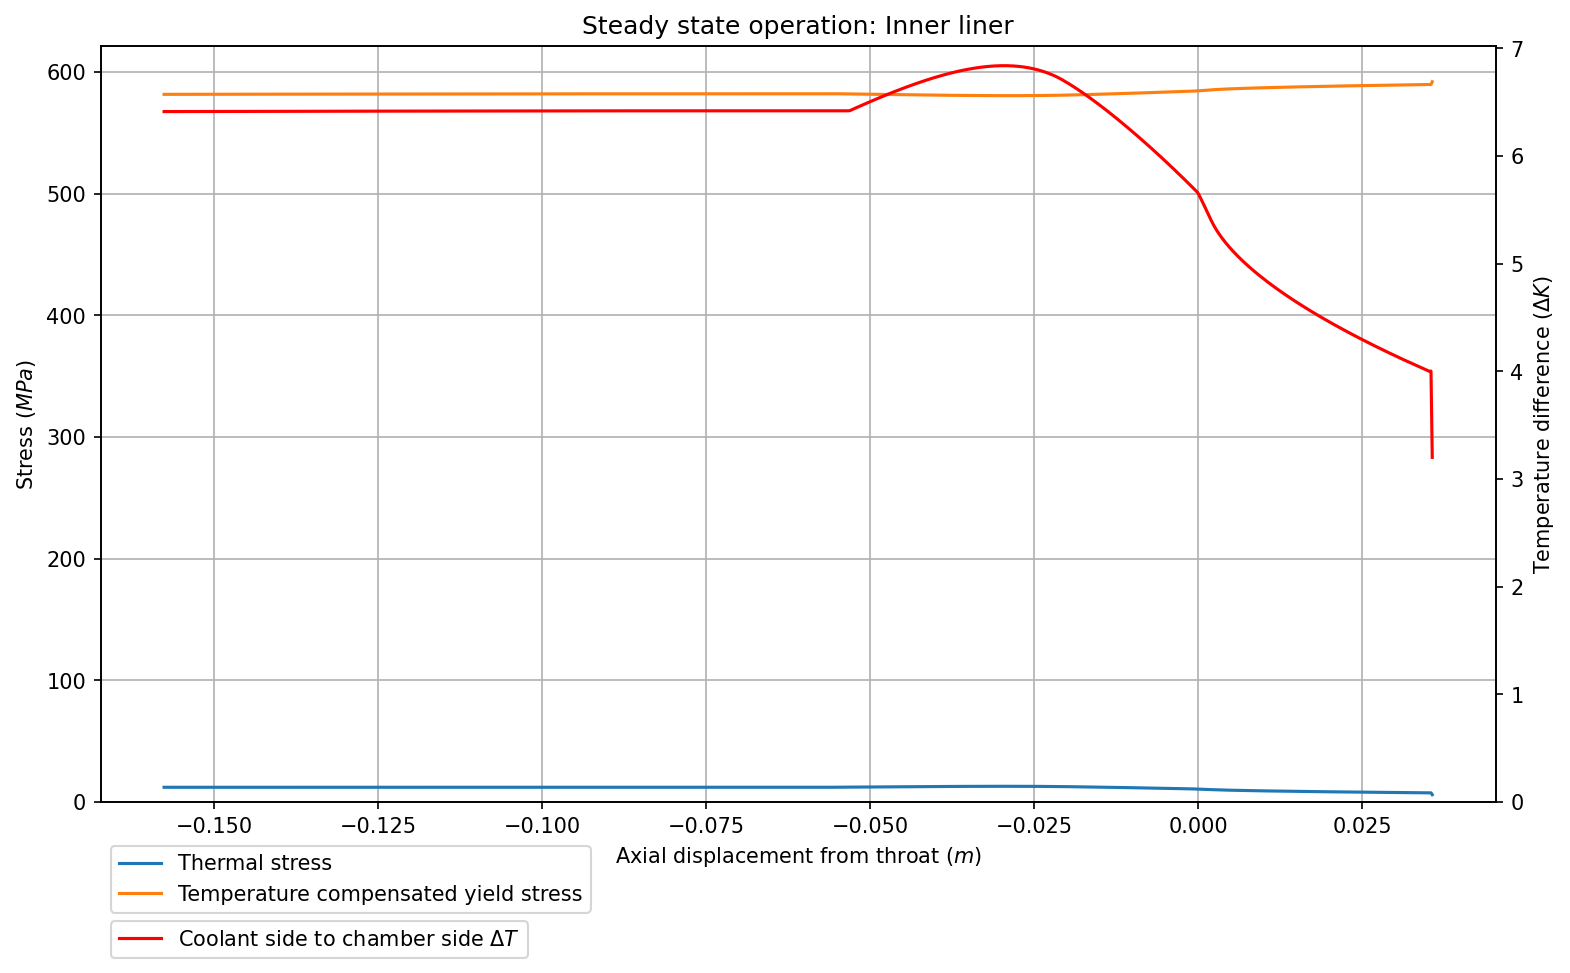

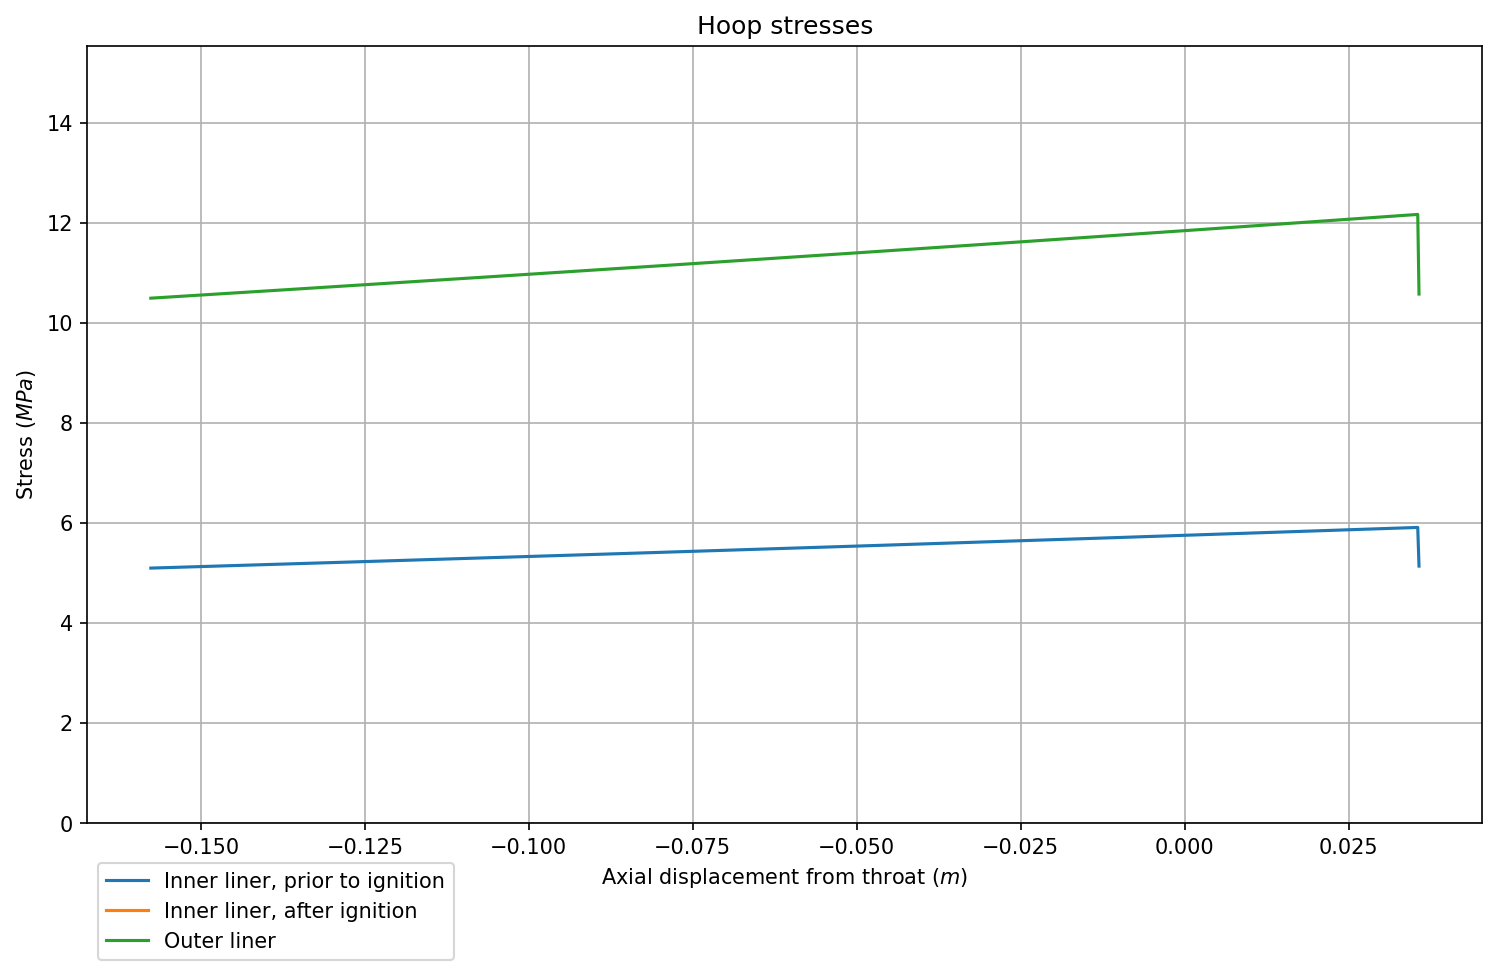

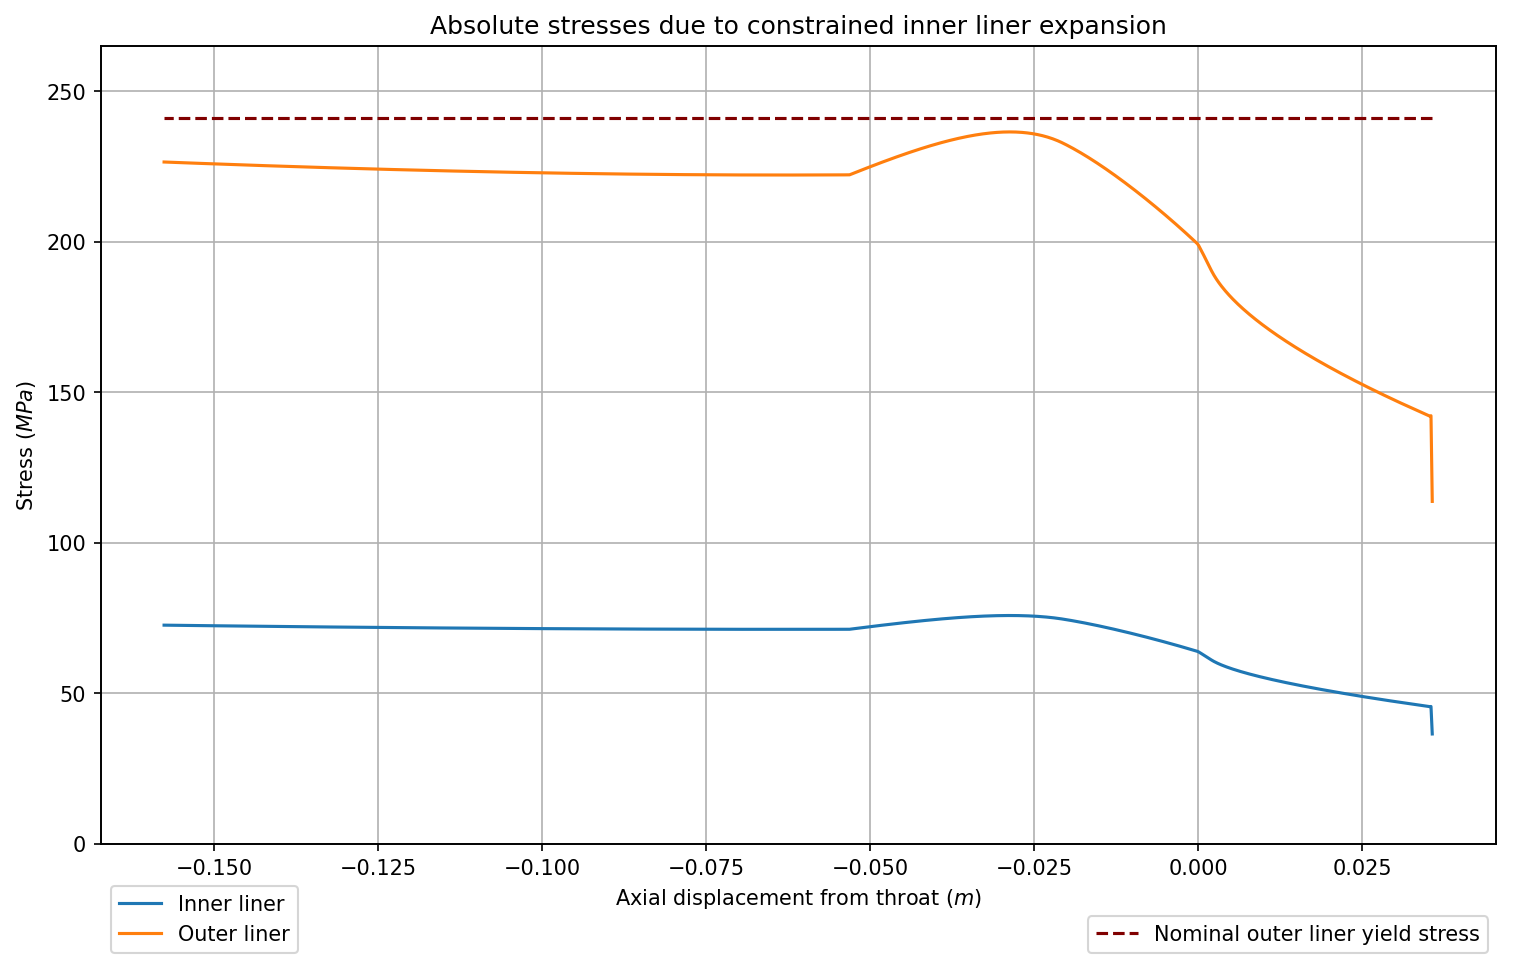

In [28]:
#Graph results - copied from Henry Free's stress_example.py
xs = heating_data["x"]
threshold = 0.5

#If a hoop or inner expansion stress exceeds this proportion of nominal yield stress,
#then show the nominal yield stress on the plot to make it clear this could be problematic
fig1, axs1 = plt.subplots(figsize=(12, 7))
fig2, axs2 = plt.subplots(figsize=(12, 7))
fig3, axs3 = plt.subplots(figsize=(12, 7))

axs1.plot(xs, steady_stress["thermal_stress"]/1E6, label = "Thermal stress")
axs1.plot(xs, steady_stress["yield_adj"]/1E6, label = "Temperature compensated yield stress")
axs1.set_title("Steady state operation: Inner liner")
axs1.set_xlabel("Axial displacement from throat $(m)$")
axs1.set_ylabel("Stress $(MPa)$")
axs1.set_ylim([0, None])
axs1.legend(bbox_to_anchor = (0, -0.16), loc = "lower left")
axs1.grid()

axs1_2 = axs1.twinx()
axs1_2.plot(xs, steady_stress["deltaT_wall"], color = "red", label = "Coolant side to chamber side $\Delta T$")
axs1_2.set_ylabel("Temperature difference ($\Delta K$)")
axs1_2.set_ylim([0, None])
axs1_2.legend(bbox_to_anchor = (0, -0.22), loc = "lower left")
fig1.subplots_adjust(bottom = 0.16)

axs2.plot(xs, steady_stress["stress_inner_hoop_steady"]/1E6, label = "Inner liner, prior to ignition")
axs2.plot(xs, transient_stress["stress_inner_hoop_transient"]/1E6, label = "Inner liner, after ignition")
axs2.plot(xs, steady_stress["stress_outer_hoop"]/1E6, label = "Outer liner")
ymax2 = axs2.get_ylim()[1]

if np.max(steady_stress["stress_inner_hoop_steady"]) > threshold*inner_wall_material.sigma_y or \
   np.max(transient_stress["stress_inner_hoop_transient"]) > threshold*inner_wall_material.sigma_y:
    axs2i = axs2.twinx()
    axs2i.get_yaxis().set_visible(False)
    axs2i.hlines(inner_wall_material.sigma_y/1E6, xs[0], xs[-1], linestyles = "dashed", color = "indianred",
                label = "Nominal inner liner yield stress")
    ymax2 = max((ymax2, 1.1*inner_wall_material.sigma_y/1E6))
    axs2i.set_ylim(0, ymax2)
    axs2i.legend(bbox_to_anchor = (0.7, -0.11), loc = "lower left")

if np.max(steady_stress["stress_outer_hoop"]) > threshold*outer_wall_material.sigma_y:
    axs2o = axs2.twinx()
    axs2o.get_yaxis().set_visible(False)
    axs2o.hlines(outer_wall_material.sigma_y/1E6, xs[0], xs[-1], linestyles = "dashed", color = "maroon",
                label = "Nominal outer liner yield stress")
    ymax2 = max((ymax2, 1.1*outer_wall_material.sigma_y/1E6))
    try:
        axs2i.set_ylim(0, ymax2)
    except NameError:
        pass
    axs2o.set_ylim(0, ymax2)
    axs2o.legend(bbox_to_anchor = (0.7, -0.15), loc = "lower left")

axs2.set_title("Hoop stresses")
axs2.set_xlabel("Axial displacement from throat $(m)$")
axs2.set_ylabel("Stress $(MPa)$")
axs2.legend(bbox_to_anchor = (0, -0.19), loc = "lower left")
axs2.set_ylim([0, ymax2])
axs2.grid()
fig2.subplots_adjust(bottom = 0.14)

axs3.plot(xs, np.abs(transient_stress["stress_inner_IE"]/1E6), label = "Inner liner")
axs3.plot(xs, np.abs(transient_stress["stress_outer_IE"]/1E6), label = "Outer liner")
ymax3 = axs3.get_ylim()[1]

if np.max(np.abs(transient_stress["stress_inner_IE"])) > threshold*inner_wall_material.sigma_y:
    axs3i = axs3.twinx()
    axs3i.get_yaxis().set_visible(False)
    axs3i.hlines(inner_wall_material.sigma_y/1E6, xs[0], xs[-1], linestyles = "dashed", color = "indianred",
                label = "Nominal inner liner yield stress")
    ymax3 = max((ymax3, 1.1*inner_wall_material.sigma_y/1E6))
    axs3i.set_ylim(0, ymax3)
    axs3i.legend(bbox_to_anchor = (0.7, -0.11), loc = "lower left")

if np.max(np.abs(transient_stress["stress_outer_IE"])) > threshold*outer_wall_material.sigma_y:
    axs3o = axs3.twinx()
    axs3o.get_yaxis().set_visible(False)
    axs3o.hlines(outer_wall_material.sigma_y/1E6, xs[0], xs[-1], linestyles = "dashed", color = "maroon",
                label = "Nominal outer liner yield stress")
    ymax3 = max((ymax3, 1.1*outer_wall_material.sigma_y/1E6))
    try:
        axs3i.set_ylim(0, ymax3)
    except NameError:
        pass
    axs3o.set_ylim(0, ymax3)
    axs3o.legend(bbox_to_anchor = (0.7, -0.15), loc = "lower left")

axs3.set_title("Absolute stresses due to constrained inner liner expansion")
axs3.set_xlabel("Axial displacement from throat $(m)$")
axs3.set_ylabel("Stress $(MPa)$")
axs3.legend(bbox_to_anchor = (0, -0.15), loc = "lower left")
axs3.set_ylim([0, ymax3])
axs3.grid()
fig3.subplots_adjust(bottom = 0.12)

plt.show()